In [1]:
from scripts import NN
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.utils

# Part 1: Autoencoder Implementation

In [2]:
training_examples = NN.make_autoencoder_training_examples()

In [3]:
training_examples = np.array(training_examples)

In [4]:
x = training_examples
y = training_examples

In [5]:
setup = [[8,3,"sigmoid"],[3,8,"sigmoid"]]

batchSize = 8 # total number of training examples

activation = 'sigmoid'

nn = NN.NeuralNetwork(x,y,setup,activation,batchSize,is_autoencoder=True,lr=.01,seed=1,iters=15000)


In [6]:
loss_iter_sample = nn.fit()

In [7]:
data = []
for i in range(8):
    target = [0,0,0,0,0,0,0,0]
    target[i] = 1
    out = nn.predict(target)
    data.append((target, out))
#nn.predict([1,0,0,0,0,0,0,0])

In [8]:
data

[([1, 0, 0, 0, 0, 0, 0, 0], array([1., 0., 0., 0., 0., 0., 0., 0.])),
 ([0, 1, 0, 0, 0, 0, 0, 0], array([0., 1., 0., 0., 0., 0., 0., 0.])),
 ([0, 0, 1, 0, 0, 0, 0, 0], array([0., 0., 1., 0., 0., 0., 0., 0.])),
 ([0, 0, 0, 1, 0, 0, 0, 0], array([0., 0., 0., 1., 0., 0., 0., 0.])),
 ([0, 0, 0, 0, 1, 0, 0, 0], array([0., 0., 0., 0., 1., 0., 0., 0.])),
 ([0, 0, 0, 0, 0, 1, 0, 0], array([0., 0., 0., 0., 0., 1., 0., 0.])),
 ([0, 0, 0, 0, 0, 0, 1, 0], array([0., 0., 0., 0., 0., 0., 1., 0.])),
 ([0, 0, 0, 0, 0, 0, 0, 1], array([0., 0., 0., 0., 0., 0., 0., 1.]))]

# Part 2: Adapt for Classification, and develop training regime

#### Question 2a) Process of Encoding DNA Sequences:  
  
DNA sequences were one-hot encoded such that each nucleobase in the sequence was converted to a bitvector of length 4, with only one on-bit, the location of which indicates the nucleobase's identity (for example, A --> [1,0,0,0], and T --> [0,1,0,0] and so forth).  This representation should improve the network's performance over the case where the representation has A=0, T=1, C=2, and G=3, because in that latter representation, the network might mistakenly treat A and T as more similar than A and G (which is not biologically accurate).


#### Question 3a) Describe your training regime  
  
My training regime (or, my .fit() method) simply performs Stochastic Gradient Descent, but for only a subset of the data in each iteration.  In each iteration, .fit() shuffles the input data and the labels, then a certain number of examples (batchSize specifies this number) are used to adjust the weights and biases of the network through Stochastic Gradient Descent.  This method of training on only a fraction of the input samples was implemented to speed up the training process.  
  
In order to prevent the negative training data from overwhelming the positive training data, the standalone function make_training_examples only returns 3 negative examples for every positive example.

In [9]:
pos_file = 'data/rap1-lieb-positives.txt' # got rid of ../ at beginning for nb
neg_file = 'data/yeast-upstream-1k-negative.fa'

seq_training_examples = NN.make_training_examples(pos_file, neg_file)

In [10]:
setup = [[68,25],[25,1]]

x = [NN.one_hot_encode_dna(seq) for seq in seq_training_examples]
y = [value for value in seq_training_examples.values()] # since python3 has ordered dicts, the values should line up with their keys

batchSize = 30

# the first 137 samples are positives, the next 411 are negatives
# make a test set with 10% of the positives and 10% of the negatives (14 and 41)
x_test = x[:14]+x[-41:]
y_test = y[:14]+y[-41:]

x_train = x[14:-41]
y_train = y[14:-41]

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [11]:
classifier_nn = NN.NeuralNetwork(x_train,y_train,setup,activation,batchSize,is_autoencoder=False,lr=0.01,seed=1,iters=10000)


In [12]:
classifier_loss_iter_sample = classifier_nn.fit()

In [13]:
num_correct = 0
pred_pos = 0
for i in range(len(x_test)):
    if np.round(classifier_nn.predict(x_test[i])) == y_test[i]:
        num_correct+=1
    if np.round(classifier_nn.predict(x_test[i])) == 1:
        pred_pos += 1
        
print(num_correct/len(x_test))
print(pred_pos/len(x_test))

1.0
0.2545454545454545


#### Question 4a) Show the input and output for one true positive sequence and one true negative sequence

In [14]:
# A true positive example.  x[0] is the input and y[0] is x[0]'s target output

print(x_test[0])
print(y_test[0])

print(classifier_nn.predict(x_test[0]))

[1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
1
[[0.94182603]]


In [15]:
# A true negative example.

print(x_test[-1])
print(y_test[-1])

print(classifier_nn.predict(x_test[-1]))

[0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0]
0
[[1.98919939e-08]]


#### Question 4b) Network architecture, results of training, and performance in minimizing error  
  
My network architecture has a 68-node input later, which is fully connected to a 25-node hidden layer, which is fully connected to a one-node output layer.  
  
The results of the training were very successful, as the network was able to correctly predict whether each of the 55 test examples was a Rap1 binding site.  
  
The network successfully minimized the loss over its 10,000 iterations, as seen below (the three numbers in the tuples below are (loss, iteration, sample in that iteration)).  
  
#### Question 4c) What was the stop criterion for convergence of your learned parameters? How did you decide this?  
  
Since I only had 548 examples, my batch size was 30, and I only trained for 10k iterations, I did not implement a stop criterion for convergence, since network training did not take long with the aforementioned parameters and the model performed very well in its prediction task.  Plus, by manually inspecting the decrease in loss over iterations during network training, I was able to confirm that the lost decreases then stabilizes over training iterations.  


In [16]:
# Examples values for Question 4b:

print(classifier_loss_iter_sample[0])
print(classifier_loss_iter_sample[1])
print(classifier_loss_iter_sample[500])
print(classifier_loss_iter_sample[-1])

(0.9999974309965792, 1, 0)
(0.9999972957699784, 1, 1)
(0.05837916935825106, 17, 20)
(3.9289120179151686e-16, 10000, 29)


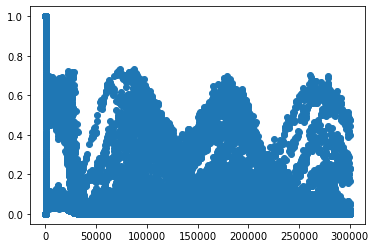

In [17]:
losses = [loss for loss, it, sample in classifier_loss_iter_sample]

# print(list(range(len(losses))))

plt.scatter(list(range(len(losses))), losses)
plt.show()

# Part 3: Cross-Validation  
  
#### Question 5a)

I can use k-fold cross validation to determine my model's performance by splitting the data into k groups, and treating each of the groups as a test set for a model trained on the other k-1 groups.  This helps determine whether the model can learn to make accurate predictions for each subset of the data.

In [18]:
# Testing different values of k for k-fold cross validation

data = []

shuffled = sklearn.utils.shuffle(x, y)
x_shuffled, y_shuffled = shuffled[0], shuffled[1]

for k in range(2,10):

    groupSize = len(x_shuffled) // k

    for i in range(k):
        x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
        y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

        x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
        y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

        classifier_nn = NN.NeuralNetwork(x_train,y_train,setup,activation,batchSize,is_autoencoder=False,lr=0.01,seed=1,iters=10000)

        cv_loss_iter_sample = classifier_nn.fit()

        # Calculate the accuracy of the model for the current data split
        num_correct = 0
        pred_pos = 0
        for j in range(len(x_test)):
            if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
                num_correct+=1
            if np.round(classifier_nn.predict(x_test[j])) == 1:
                pred_pos += 1

        print('k = %d' % k)
        print('i = %d' % i)
        print(num_correct/len(x_test))
        print(pred_pos/len(x_test))

        data.append((k, i, num_correct/len(x_test), pred_pos/len(x_test)))


k = 2
i = 0
0.9781021897810219
0.26277372262773724
k = 2
i = 1
0.9927007299270073
0.2664233576642336
k = 3
i = 0
0.989010989010989
0.2692307692307692
k = 3
i = 1
0.9725274725274725
0.26373626373626374
k = 3
i = 2
0.989010989010989
0.2692307692307692
k = 4
i = 0
0.9781021897810219
0.29927007299270075
k = 4
i = 1
0.9635036496350365
0.24087591240875914
k = 4
i = 2
1.0
0.24087591240875914
k = 4
i = 3
0.9927007299270073
0.2846715328467153
k = 5
i = 0
0.9724770642201835
0.30275229357798167
k = 5
i = 1
0.981651376146789
0.22018348623853212
k = 5
i = 2
0.981651376146789
0.28440366972477066
k = 5
i = 3
1.0
0.25688073394495414
k = 5
i = 4
0.9908256880733946
0.25688073394495414
k = 6
i = 0
0.967032967032967
0.31868131868131866
k = 6
i = 1
1.0
0.23076923076923078
k = 6
i = 2
0.9560439560439561
0.25274725274725274
k = 6
i = 3
1.0
0.26373626373626374
k = 6
i = 4
0.978021978021978
0.2857142857142857
k = 6
i = 5
0.989010989010989
0.26373626373626374
k = 7
i = 0
0.9743589743589743
0.3076923076923077
k 

In [19]:
# Didn't include k=10 in the loop above, so adding it here

k = 10

groupSize = len(x_shuffled) // k

for i in range(k):
    x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
    y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

    x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
    y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

    classifier_nn = NN.NeuralNetwork(x_train,y_train,setup,activation,batchSize,is_autoencoder=False,lr=0.01,seed=1,iters=10000)

    cv_loss_iter_sample = classifier_nn.fit()

    # Calculate the accuracy of the model for the current data split
    num_correct = 0
    pred_pos = 0
    for j in range(len(x_test)):
        if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
            num_correct+=1
        if np.round(classifier_nn.predict(x_test[j])) == 1:
            pred_pos += 1

    print('k = %d' % k)
    print('i = %d' % i)
    print(num_correct/len(x_test))
    print(pred_pos/len(x_test))

    data.append((k, i, num_correct/len(x_test), pred_pos/len(x_test)))


k = 10
i = 0
0.9629629629629629
0.35185185185185186
k = 10
i = 1
0.9814814814814815
0.25925925925925924
k = 10
i = 2
1.0
0.2222222222222222
k = 10
i = 3
0.9444444444444444
0.24074074074074073
k = 10
i = 4
0.9814814814814815
0.2777777777777778
k = 10
i = 5
0.9814814814814815
0.2962962962962963
k = 10
i = 6
0.9814814814814815
0.24074074074074073
k = 10
i = 7
1.0
0.25925925925925924
k = 10
i = 8
0.9814814814814815
0.24074074074074073
k = 10
i = 9
1.0
0.3148148148148148


In [20]:
data

[(2, 0, 0.9781021897810219, 0.26277372262773724),
 (2, 1, 0.9927007299270073, 0.2664233576642336),
 (3, 0, 0.989010989010989, 0.2692307692307692),
 (3, 1, 0.9725274725274725, 0.26373626373626374),
 (3, 2, 0.989010989010989, 0.2692307692307692),
 (4, 0, 0.9781021897810219, 0.29927007299270075),
 (4, 1, 0.9635036496350365, 0.24087591240875914),
 (4, 2, 1.0, 0.24087591240875914),
 (4, 3, 0.9927007299270073, 0.2846715328467153),
 (5, 0, 0.9724770642201835, 0.30275229357798167),
 (5, 1, 0.981651376146789, 0.22018348623853212),
 (5, 2, 0.981651376146789, 0.28440366972477066),
 (5, 3, 1.0, 0.25688073394495414),
 (5, 4, 0.9908256880733946, 0.25688073394495414),
 (6, 0, 0.967032967032967, 0.31868131868131866),
 (6, 1, 1.0, 0.23076923076923078),
 (6, 2, 0.9560439560439561, 0.25274725274725274),
 (6, 3, 1.0, 0.26373626373626374),
 (6, 4, 0.978021978021978, 0.2857142857142857),
 (6, 5, 0.989010989010989, 0.26373626373626374),
 (7, 0, 0.9743589743589743, 0.3076923076923077),
 (7, 1, 0.9871794871794

In [21]:
accuracies = []

for k in range(2,11):
    sum = 0
    for i in range(k):
        sum += data[i+k-2][2]
    accuracies.append((k, sum/k))

accuracies

[(2, 0.9854014598540146),
 (3, 0.9847463971551563),
 (4, 0.9821629100826181),
 (5, 0.980628860190904),
 (6, 0.9826324370957064),
 (7, 0.981440912265261),
 (8, 0.98535123551865),
 (9, 0.9873710223941257),
 (10, 0.9842383157591087)]

#### Question 5b)

I selected a k-value of 10 because k values of 2-10 all gave high accuracies within 1% of each other, and it is a standard practice to use 9:1 train:test split.

In [22]:
# Use k=10 to determine model's performance

accuracy = 0
accuracies = []

k = 10

groupSize = len(x_shuffled) // k

for i in range(k):
    x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
    y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

    x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
    y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

    classifier_nn = NN.NeuralNetwork(x_train,y_train,setup,activation,batchSize,is_autoencoder=False,lr=0.01,seed=1,iters=10000)

    cv_loss_iter_sample = classifier_nn.fit()

    # Calculate the accuracy of the model for the current data split
    num_correct = 0
    pred_pos = 0
    for j in range(len(x_test)):
        if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
            num_correct+=1
        if np.round(classifier_nn.predict(x_test[j])) == 1:
            pred_pos += 1

    accuracy += num_correct/len(x_test)
    accuracies.append(num_correct/len(x_test))

print(accuracies)
accuracy = accuracy / k
accuracy

[0.9629629629629629, 0.9814814814814815, 1.0, 0.9444444444444444, 0.9814814814814815, 0.9814814814814815, 0.9814814814814815, 1.0, 0.9814814814814815, 1.0]


0.9814814814814816

#### Question 5c)

The accuracy of the model's predictions for each of the 10 folds is very high (between 94-100%).  Thus, the model performed well under cross validation.

# Part 4: Extension

Vary hyperparameters and determine their effects on model performance.

Hyperparameters tested:  
1) Learning Rate  
2) Hidden Layer Size  
3) Using ReLU activation function instead of sigmoid

In [23]:
# 1) Vary Learning Rate

lr_data = []

for lr in range(1, 102, 10): #range(0.01, 1.02, 0.1):
    lr = lr/100
    
    accuracy = 0
    accuracies = []

    k = 10

    groupSize = len(x_shuffled) // k

    for i in range(3): # only test 3 groups for speed
        x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
        y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

        x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
        y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

        classifier_nn = NN.NeuralNetwork(x_train,y_train,setup,activation,batchSize,is_autoencoder=False,lr=lr,seed=1,iters=10000)

        cv_loss_iter_sample = classifier_nn.fit()

        # Calculate the accuracy of the model for the current data split
        num_correct = 0
        pred_pos = 0
        for j in range(len(x_test)):
            if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
                num_correct+=1
            if np.round(classifier_nn.predict(x_test[j])) == 1:
                pred_pos += 1

        accuracy += num_correct/len(x_test)
        #accuracies.append(num_correct/len(x_test))

    #print(accuracies)
    accuracy = accuracy / 3
    #accuracy
    
    lr_data.append((lr, accuracy))

/Users/benjaminorr/UCSFben/Classes/Algorithms/Project3/scripts/NN.py:143: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [36]:
# Accidentally div accuracy by k instead of 3 above

actual_accuracies = [(lr, accuracy*10/3) for lr, accuracy in lr_data]
actual_accuracies

[(0.01, 0.9814814814814815),
 (0.11, 0.7839506172839507),
 (0.21, 0.7777777777777777),
 (0.31, 0.7777777777777777),
 (0.41, 0.8518518518518517),
 (0.51, 1.0),
 (0.61, 0.9876543209876543),
 (0.71, 0.9938271604938272),
 (0.81, 1.0),
 (0.91, 1.0),
 (1.01, 0.9938271604938272)]

In [33]:
# 2) Vary Hidden Layer Size

lr = 0.01

hidden_size_data = []

for hidden_size in range(5, 80, 10):
    
    hidden_size_setup = [[68,hidden_size],[hidden_size,1]]
    
    accuracy = 0
    accuracies = []

    k = 10

    groupSize = len(x_shuffled) // k

    for i in range(3):
        x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
        y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

        x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
        y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

        classifier_nn = NN.NeuralNetwork(x_train,y_train,hidden_size_setup,activation,batchSize,is_autoencoder=False,lr=lr,seed=1,iters=10000)

        hs_loss_iter_sample = classifier_nn.fit()

        # Calculate the accuracy of the model for the current data split
        num_correct = 0
        pred_pos = 0
        for j in range(len(x_test)):
            if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
                num_correct+=1
            if np.round(classifier_nn.predict(x_test[j])) == 1:
                pred_pos += 1

        accuracy += num_correct/len(x_test)
        #accuracies.append(num_correct/len(x_test))

    #print(accuracies)
    accuracy = accuracy / 3
    #accuracy
    
    hidden_size_data.append((hidden_size, accuracy))

In [34]:
hidden_size_data

[(5, 0.7407407407407408),
 (15, 0.8888888888888888),
 (25, 0.9814814814814815),
 (35, 0.9938271604938271),
 (45, 0.9938271604938271),
 (55, 0.9938271604938271),
 (65, 0.9876543209876543),
 (75, 1.0)]

In [37]:
# 3) Use ReLU activation function instead of sigmoid

activation = 'relu'

lr = 0.01

setup = [[68,25], [25,1]]

relu_data = []

accuracy = 0
accuracies = []

k = 10

groupSize = len(x_shuffled) // k

for i in range(3):
    x_test = x_shuffled[i*groupSize:(i+1)*groupSize]
    y_test = y_shuffled[i*groupSize:(i+1)*groupSize]

    x_train = x_shuffled[:i*groupSize] + x_shuffled[(i+1)*groupSize:]
    y_train = y_shuffled[:i*groupSize] + y_shuffled[(i+1)*groupSize:]

    classifier_nn = NN.NeuralNetwork(x_train,y_train,hidden_size_setup,activation,batchSize,is_autoencoder=False,lr=lr,seed=1,iters=10000)

    relu_loss_iter_sample = classifier_nn.fit()

    # Calculate the accuracy of the model for the current data split
    num_correct = 0
    pred_pos = 0
    for j in range(len(x_test)):
        if np.round(classifier_nn.predict(x_test[j])) == y_test[j]:
            num_correct+=1
        if np.round(classifier_nn.predict(x_test[j])) == 1:
            pred_pos += 1

    accuracy += num_correct/len(x_test)
    relu_data.append(num_correct/len(x_test))

#print(accuracies)
accuracy = accuracy / 3
#accuracy

print(relu_data)
print(accuracy)


[0.6851851851851852, 0.7592592592592593, 0.7777777777777778]
0.7407407407407408


In [44]:
print('Learning Rate Results:')
display(actual_accuracies)
print('Hidden Size Results:')
display(hidden_size_data)
print('ReLU Activation Results:')
display(relu_data)

Learning Rate Results:


[(0.01, 0.9814814814814815),
 (0.11, 0.7839506172839507),
 (0.21, 0.7777777777777777),
 (0.31, 0.7777777777777777),
 (0.41, 0.8518518518518517),
 (0.51, 1.0),
 (0.61, 0.9876543209876543),
 (0.71, 0.9938271604938272),
 (0.81, 1.0),
 (0.91, 1.0),
 (1.01, 0.9938271604938272)]

Hidden Size Results:


[(5, 0.7407407407407408),
 (15, 0.8888888888888888),
 (25, 0.9814814814814815),
 (35, 0.9938271604938271),
 (45, 0.9938271604938271),
 (55, 0.9938271604938271),
 (65, 0.9876543209876543),
 (75, 1.0)]

ReLU Activation Results:


[0.6851851851851852, 0.7592592592592593, 0.7777777777777778]

### Part 4 Questions:
  
 - The set of learning parameters that worked best were:
     - Learning Rate = 0.51, 0.81, or 0.91 (100% accuracy)
     - Hidden Layer Size = 75 nodes (100% accuracy)
     - Activation Function = Sigmoid (ReLU activation function led to lower prediction accuracies)  
  
     
 - When more nodes were added to the hidden layer, the predictive abilities of the neural network improved.  This is likely because the added learnable parameters allowed the network to learn more features of the input data, and use those additional features to improve the accuracy of the predictions.  
  
     
 - Other hyperparameters that affected performance were: learning rate and choice of activation function.  Certain learning rates (50 - 90 times greater than the one I initially used) improved the performance of the network.  Use of the ReLU activation function by the network instead of the sigmoid activation function decreased the accuracy of the network's predictions by ~25%.


# Part 5: Evaluate Network on Final Set

Using learning_rate = 0.01, and hidden layer size = 75 nodes

In [110]:
test_seqs = []
test_file = 'data/rap1-lieb-test.txt'

with open(test_file, 'r') as f:
    for line in f:
        test_seqs.append(line.rstrip())

In [111]:
test_seqs_one_hot = [NN.one_hot_encode_dna(seq) for seq in test_seqs]

In [112]:
x = [NN.one_hot_encode_dna(seq) for seq in seq_training_examples]
y = [value for value in seq_training_examples.values()]

In [113]:
shuffled2 = sklearn.utils.shuffle(x, y)
x_shuffled2, y_shuffled2 = shuffled2[0], shuffled2[1]

In [121]:
lr = 0.01
hidden_size = 75
setup = [[68,hidden_size],[hidden_size,1]]
batchSize = 30
activation = 'sigmoid'

best_nn = NN.NeuralNetwork(x_shuffled2,y_shuffled2,setup,activation,batchSize,is_autoencoder=False,lr=lr,seed=1,iters=10000)

In [122]:
best_loss_iter_sample = best_nn.fit()

In [123]:
# Tab-separated output:

for i in range(len(test_seqs_one_hot)):
    print('%s\t%.3f' % (test_seqs[i], best_nn.predict(test_seqs_one_hot[i])[0][0]))

AAAAAAACGCAACTAAT	0.001
AAAAACACACATCTGGC	0.270
AAAACCAAACACCTGAA	0.970
AAAACCAAACAGCTCAG	0.960
AAAACCAAACATATCAA	0.959
AAAACCAAACATATCAA	0.959
AAAACCACACACATCGC	0.968
AAAACCACACCTTGTAT	0.892
AAAACCAGACATACTAA	0.867
AAAACCAGACCCTTTAC	0.868
AAAACCAGGCACCAAGG	0.653
AAAACCATACACATTCG	0.976
AAAACCATAGACTTCTC	0.777
AAAACCATCCATCCTGT	0.912
AAAACCATGCAGTTCTT	0.868
AAAACCATGCCGTTGAA	0.721
AAAACCATTCCCAACAA	0.877
AAAACCTTACATTGTTC	0.796
AAAAGCACGCATCCGGC	0.101
AAAAGCACGCATCCGGC	0.101
AAAAGCATACCCCGCAC	0.947
AAAAGCATGCACCTTGC	0.459
AAAATCATACATTTCCA	0.723
AAAATCATACATTTCGG	0.656
AAACACACAAACGCCAG	0.081
AAACACACAAACGCCAG	0.081
AAACACACACACACAAA	0.606
AAACACACACACTCACC	0.595
AAACACAGATACCTCGA	0.327
AAACACATACACCTTAA	0.989
AAACACATACATTACCA	0.990
AAACACATGCACGCCAC	0.925
AAACACATGTCCCACGA	0.269
AAACACATTCATCTCTT	0.836
AAACACGTACCTCGTGA	0.925
AAACCAACACCTAGGGC	0.235
AAACCAAGACACCTCCT	0.963
AAACCAGTTCATCACTT	0.813
AAACCATTACATTATGT	0.686
AAACCCAAACAATTGTT	0.861
AAACCCAAACACCACAT	0.999
AAACCCAAACAGGTCG

GACTTGAAACACTTCAA	0.003
GAGAACGCACATCCCAA	0.118
GAGACCAAACACCACTT	0.594
GAGACCATACAGCTTCC	0.681
GAGACCATCCACGTTGT	0.040
GAGACCATTCTCCCCAT	0.287
GAGATCACAGACCTTGA	0.000
GAGATGATGCCCTCCTA	0.000
GAGCACATAGCCATGGA	0.001
GAGCCAATGCACTAAAC	0.349
GAGCCAATGCATTTCAA	0.708
GAGCCAATGCATTTCAA	0.708
GAGCCCAAACAAAAGAG	0.480
GAGCCCAAAGACTGCGA	0.211
GAGCCCAAATATCTTGT	0.081
GAGCCCAAGCATTGAAA	0.516
GAGCCCACACAAATCCA	0.688
GAGCCCACACCCATTGC	0.444
GAGCCCAGGCCTCCGTG	0.245
GAGCCCATACGTTCCTC	0.905
GAGCCCATACGTTCCTC	0.905
GAGCCCATGCATCTATA	0.868
GAGCCCATGCATTGTAC	0.968
GAGCCCATTCACAAAGA	0.580
GAGCCCGCGCACTTCCT	0.841
GAGCCCGTACACAATGA	0.956
GAGCCCTTGCACGCAAA	0.374
GAGCCGGTACAAGTCTT	0.045
GAGCGCACCCACCCGAG	0.068
GAGCTCATAGACCCTCT	0.015
GAGCTCGCTTATCTTAA	0.000
GAGGCCAAACATCCTGT	0.343
GAGGCCGCACACTAAGA	0.294
GAGTACAAACAAGTCGC	0.001
GAGTACACGGCCACCAA	0.000
GAGTACATGCAACTTGA	0.018
GAGTACATTCATTTCTC	0.031
GAGTACATTTACTCGAG	0.002
GAGTAGATACACCCTAG	0.028
GAGTCCACACAGGAGGA	0.226
GAGTCCACGAACTAGCT	0.006
GAGTCCACTCAGCTCC

TCGGCCAGGGACTTGTT	0.001
TCGGCCATAAAACTCAT	0.265
TCGGTCATACATACGTA	0.024
TCGTACAAAGACCTCTC	0.001
TCGTACAAAGACCTCTC	0.001
TCGTACATACCGGCCTC	0.014
TCGTACATATACTTCAA	0.075
TCGTCCAAACAACGCCA	0.870
TCGTCCAAACACAAAAG	0.609
TCGTCCAAGAACTCAAA	0.005
TCGTCCACACCAGCGTC	0.010
TCGTCCACATACTTGTT	0.023
TCGTCCACGCCTGTCGT	0.165
TCGTCCACGCTCCTTAA	0.323
TCGTCCACGTACGTTAC	0.002
TCGTCCATACATCATAA	0.995
TCGTCCATACATGACTC	0.983
TCGTCCATAGCTCTCAG	0.759
TCGTCCATTCCCTTGTT	0.255
TCGTCCGTACATTGGGA	0.977
TCGTCCGTGCAGCTCTC	0.875
TCGTCCGTGCAGCTCTC	0.875
TCGTCCGTGCAGCTCTC	0.875
TCGTCCTCACATCGTAT	0.750
TCGTCCTTAGACTTGAA	0.149
TCGTCGAGCCACGCCAA	0.008
TCGTCTATAAACTTCAA	0.027
TCGTGCAAGGACTTCTC	0.000
TCGTGCATGCCTCTTAA	0.150
TCGTGCCTACACGCGCA	0.035
TCGTTAAAGCACCAGAA	0.001
TCGTTCAAAAACAAGAA	0.001
TCGTTCACACAGCCGTT	0.018
TCGTTCACATACCTTGC	0.001
TCGTTCACGCACTAAAG	0.025
TCGTTCAGGCCCGTGTA	0.000
TCGTTCATTCGCTTCTA	0.005
TCTACCAAACACCTAAT	0.391
TCTACCATCCACTTCTC	0.247
TCTCCCAAACCCGACCA	0.671
TCTCCCAGATACCTGAA	0.545
TCTCCCATACACACTC